# Problem Definition

Sentiment analysis is a method used in natural language processing that involves taking emotions from certain raw texts. To automatically determine if certain users are favourable or negative and why, this is typically used on social media postings and consumer reviews. This project aims to demonstrate the use of Python for sentiment analysis. Here, we'll make use of some review data. One customer review constitutes each observation. Each customer review includes an overall rating and a brief description of the consumer's experience. We are attempting to determine for each textual review whether it correlates to a positive review in which the customer is satisfied or a negative review in which the consumer is dissatisfied.

# Import Libraries

In [1]:
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import pos_tag
from funcsigs import signature
from sklearn.metrics import auc
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# Data Mining

We first start by loading the raw data. Each textual reviews is splitted into a positive part and a negative part. We group them together in order to start with only raw text data and no other information.

In [2]:
data = pd.read_csv("reviews.csv")
data["text"] = data["Negative"] + data["Positive"]
data["category"] = data["Score"].apply(lambda x: 1 if x < 5 else 0)
data = data[["text", "category"]]

# Data Preparation

If the user doesn't leave any negative feedback comment, this will appear as No Negative in our data. This is the same for the positive comments with the default value No Positive. We have to remove those parts from our texts. The next step consists in cleaning the text data with various operations. To clean textual data, we call our custom 'clean_text' function that performs several transformations:

- Lower the text
- Tokenize the text and remove the punctuation
- Remove useless words that contain numbers
- Remove useless stop words.
- POS tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
- Lemmatize the text: transform every word into their root form

In [3]:
def getType(position):
    if position.startswith('J'):
        return wordnet.ADJ
    elif position.startswith('V'):
        return wordnet.VERB
    elif position.startswith('N'):
        return wordnet.NOUN
    elif position.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def mineData(line):
    line = line.lower()
    line = [word.strip(string.punctuation) for word in line.split(" ")]
    line = [word for word in line if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    line = [x for x in line if x not in stop]
    line = [x for x in line if len(x) > 0]
    pos_tags = pos_tag(line)
    line = [WordNetLemmatizer().lemmatize(x[0], getType(x[1])) for x in pos_tags]
    line = [x for x in line if len(x) > 1]
    line = " ".join(line)
    return line


data = data.sample(frac=0.1, replace=False, random_state=42)
data["text"] = data["text"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))
data["refined"] = data["text"].apply(lambda x: mineData(x))

# Feature engineering

As we may assume that client reviews are closely related to how they felt about their hotel stay, we initially implement sentiment analysis tools. We employ Vader, a sentiment analysis-focused component of the NLTK module. Vader searches through his vocabulary to determine whether words are favourable or negative. To calculate the sentiment ratings, the sentence context is also taken into consideration. Vader returns 4 values for every text:

- a score for neutrality
- a score for positivity
- a score for negativity
- a final score that combines the individual scores.

Extraction of vector representations for each review is the next stage. By leveraging the circumstances in which they appear, the Gensim module generates a numerical vector representation of each word in the corpus. Shallow neural networks are used to carry out this. It's interesting to see that words with similar meanings will have comparable representation vectors.

The term vectors may also be used to convert each paragraph into a numerical vector. We may utilise those vectors as training features because equivalent representations for the same texts will also exist. Our text data must first be used to train a Doc2Vec model. We may obtain such representation vectors by using this model on our reviews. The TF-IDF values for each word and each document are then added.

But why not just keep track of how often each term appears in each document? This approach has a flaw in that it disregards the relative weight of words within the texts. A term that appears in practically all texts is unlikely to provide insightful data for analysis. On the other hand, uncommon terms could be far more ambiguous.

In [4]:
sid = SentimentIntensityAnalyzer()

data["tone"] = data["text"].apply(lambda x: sid.polarity_scores(x))
data = pd.concat([data.drop(['tone'], axis=1), data['tone'].apply(pd.Series)], axis=1)
data["review_split"] = data["text"].apply(lambda x: len(x))
data["review"] = data["text"].apply(lambda x: len(x.split(" ")))

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data["refined"].apply(lambda x: x.split(" ")))]
vec_model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
vec = data["refined"].apply(lambda x: vec_model.infer_vector(x.split(" "))).apply(pd.Series)
vec.columns = ["doc2vec_vector_" + str(x) for x in vec.columns]
data = pd.concat([data, vec], axis=1)

frequency = TfidfVectorizer(min_df=10)
result = frequency.fit_transform(data["refined"]).toarray()
freq_data = pd.DataFrame(result, columns=frequency.get_feature_names_out())
freq_data.columns = ["word_" + str(x) for x in freq_data.columns]
freq_data.index = data.index

data = pd.concat([data, freq_data], axis=1)

# Exploratory data analysis

In [5]:
data[data["review"] >= 5].sort_values("pos", ascending=False)[["text", "pos"]].head(10)

,text,pos
43101,A perfect location comfortable great value,0.931
211742,Clean comfortable lovely staff,0.907
175551,Friendly welcome Comfortable room,0.905
365085,Good location great value,0.904
109564,Clean friendly and comfortable,0.902
145743,Good value amazing location,0.901
407590,breakfast excellent Clean comfort,0.899
407546,Great place I enjoyed,0.881
218571,Beautiful Quirky Comfortable,0.878
436901,Lovely comfortable rooms,0.877


In [6]:
data[data["review"] >= 5].sort_values("neg", ascending=False)[["text", "neg"]].head(10)

,text,neg
193086,No dislikes LOCATION,0.831
356368,Nothing Great helpful wonderful staff,0.812
318516,A disaster Nothing,0.804
458794,Nothing Excellent friendly helpful staff,0.799
29666,A bit noisy No,0.796
426057,Dirty hotel Smells bad,0.762
263187,Very bad service No,0.758
443796,Nothing perfect,0.750
181508,Window blind was broken,0.744
175316,Nothing Super friendly staff,0.743


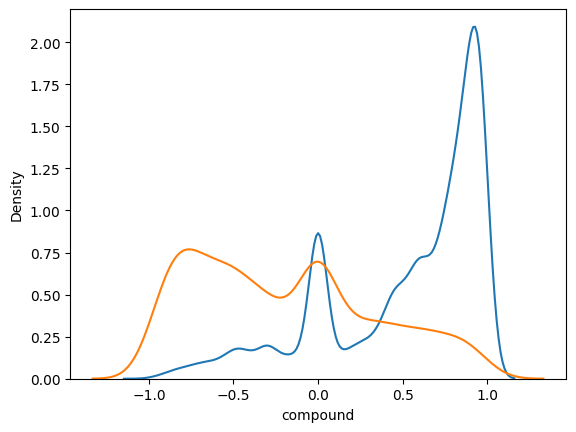

In [8]:
for x in [0, 1]:
    subset = data[data['category'] == x]
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.kdeplot(subset['compound'], label=label)

# Model Building

In [9]:
label = "category"
left = [label, "text", "refined"]
features = [c for c in data.columns if c not in left]

X_train, X_test, y_train, y_test = train_test_split(data[features], data[label], test_size=0.20, random_state=42)

forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest_model.fit(X_train, y_train)
forest_data = pd.DataFrame({"feature": features, "importance": forest_model.feature_importances_})\
    .sort_values("importance", ascending=False)
forest_data.head(20)
y_pred = [x[1] for x in forest_model.predict_proba(X_test)]

# Model Evaluation

(0.0, 1.0)

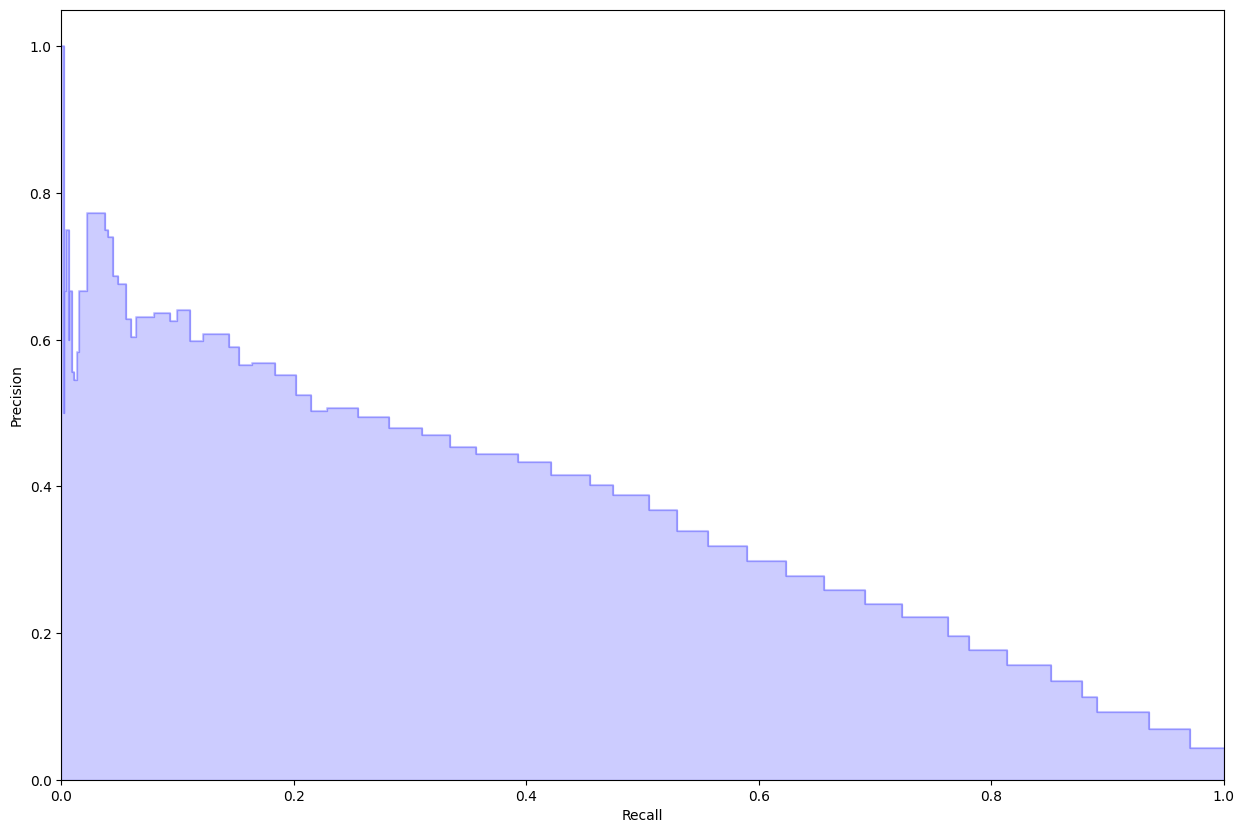

In [10]:
mean_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
args = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.figure(1, figsize=(15, 10))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **args)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# Conclusion

It is entirely feasible to generate predictions using simply raw text as the input. The ability to extract the pertinent information from this raw data source is of utmost importance. In data science projects, this sort of data is frequently a useful supplementary source that may be used to extract more learning characteristics and boost the prediction capability of the models. The AUC PR Area Under the Curve Precision Recall, also known as Average Precision, is a superior statistic in this unbalanced circumstance.

We may observe that when recall is raised, accuracy falls. This demonstrates that we must select a prediction threshold that meets our requirements.If a high recall is what we're after, we should choose a low prediction threshold that will let us detect the majority of positive class observations with just moderate accuracy. Instead, we should select a high threshold that will give us a high accuracy and a low recall if we want to be highly sure in our predictions but don't care if we don't locate all the positive observations.

We just need to utilise the AP measure to determine whether our model outperforms another classifier. We may contrast our model with a straightforward decision baseline to determine its quality.As a starting point, let's use a random classifier, which would predict the label with a 50/50 probability of 1 and 0.

A classifier with this level of precision would have a positive observation rate of 4.3%. The accuracy would remain constant for any recall value, giving us an AP of 0.043. Our model's apparent power (AP) is around 0.35, which is more than 8 times more than the apparent power of the random technique. This demonstrates the strong predictive capability of our model.